In [1]:
import os
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools


from skimage.filters import gaussian
from skimage.util import random_noise
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split



import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPool2D,Dropout,MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [2]:
# accsess the data files and dir
cancer_rays_dir     = os.listdir("dataset 1/IDC_regular_ps50_idx5") 
all_rays_dir        = "all_rays_dir"  # is this path we will put all the images
cancer_rays_dir_str ="dataset 1/IDC_regular_ps50_idx5/"

In [3]:
print(cancer_rays_dir)
print(len(cancer_rays_dir)) 

['10253', '10254', '10255', '10256', '10257', '10258', '10259', '10260', '10261', '10262', '10264', '10268', '10269', '10272', '10273', '10274', '10275', '10276', '10277', '10278', '10279', '10282', '10285', '10286', '10288', '10290', '10291', '10292', '10293', '10295', '10299', '10300', '10301', '10302', '10303', '10304', '10305', '10306', '10307', '10308', '12241', '12242', '12626', '12748', '12749', '12750', '12751', '12752', '12810', '12811', '12817', '12818', '12819', '12820', '12821', '12822', '12823', '12824', '12826', '12867', '12868', '12869', '12870', '12871', '12872', '12873', '12875', '12876', '12877', '12878', '12879', '12880', '12881', '12882', '12883', '12884', '12886', '12890', '12891', '12892', '12893', '12894', '12895', '12896', '12897', '12898', '12900', '12901', '12905', '12906', '12907', '12908', '12909', '12910', '12911', '12929', '12930', '12931', '12932', '12933', '12934', '12935', '12947', '12948', '12949', '12951', '12954', '12955', '13018', '13019', '13020', 

In [4]:
all_rays_dir_lst = os.listdir('./all_rays_dir') 

In [5]:
all_rays_dir_lst = os.listdir('./all_rays_dir') 
len(all_rays_dir_lst)

277524

In [6]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
data.head()

image_id
0  10253_idx5_x1001_y1001_class0.png
1  10253_idx5_x1001_y1051_class0.png
2  10253_idx5_x1001_y1101_class0.png
3  10253_idx5_x1001_y1151_class0.png
4  10253_idx5_x1001_y1201_class0.png

In [7]:
#Based on the addition that we added earlier in the path, we divide the data
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

data['target'] = data['image_id'].apply(extract_target)

data.head(10)

image_id target
0  10253_idx5_x1001_y1001_class0.png      0
1  10253_idx5_x1001_y1051_class0.png      0
2  10253_idx5_x1001_y1101_class0.png      0
3  10253_idx5_x1001_y1151_class0.png      0
4  10253_idx5_x1001_y1201_class0.png      0
5  10253_idx5_x1001_y1251_class0.png      0
6  10253_idx5_x1001_y1301_class0.png      0
7  10253_idx5_x1001_y1351_class0.png      0
8  10253_idx5_x1001_y1501_class0.png      0
9  10253_idx5_x1001_y1551_class0.png      0

In [8]:
def extract_patient_id(x):
    # split into a list
    a = x.split('_')
    patient_id = a[0]
    
    return patient_id
data['patient_id'] = data['image_id'].apply(extract_patient_id)
data.head()

image_id target patient_id
0  10253_idx5_x1001_y1001_class0.png      0      10253
1  10253_idx5_x1001_y1051_class0.png      0      10253
2  10253_idx5_x1001_y1101_class0.png      0      10253
3  10253_idx5_x1001_y1151_class0.png      0      10253
4  10253_idx5_x1001_y1201_class0.png      0      10253

In [9]:
data['target'].value_counts()

target
0    198738
1     78786
Name: count, dtype: int64

# Exploratory Data Analysis

### Healthy Patches

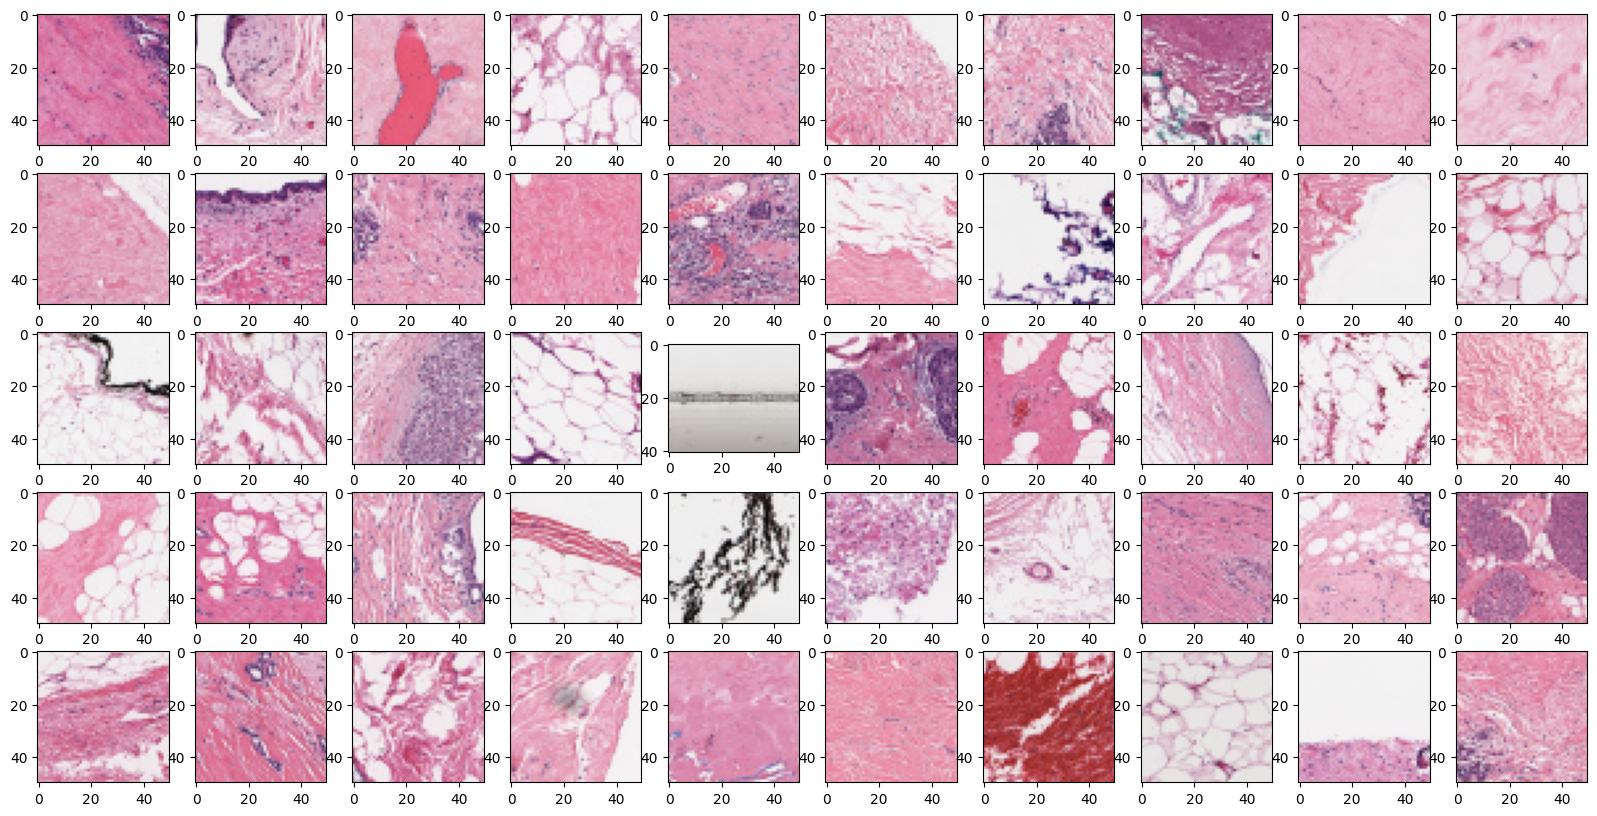

In [10]:
data.target = data.target.astype(int)  # Replace np.int with int

fig, ax = plt.subplots(5, 10, figsize=(20, 10))

pos_selection = np.random.choice(data[data.target == 1].index, size=50, replace=False)
neg_selection = np.random.choice(data[data.target == 0].index, size=50, replace=False)

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10 * n]
        path = os.path.join(all_rays_dir, data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n, m].imshow(image)
        ax[n, m].grid(False)


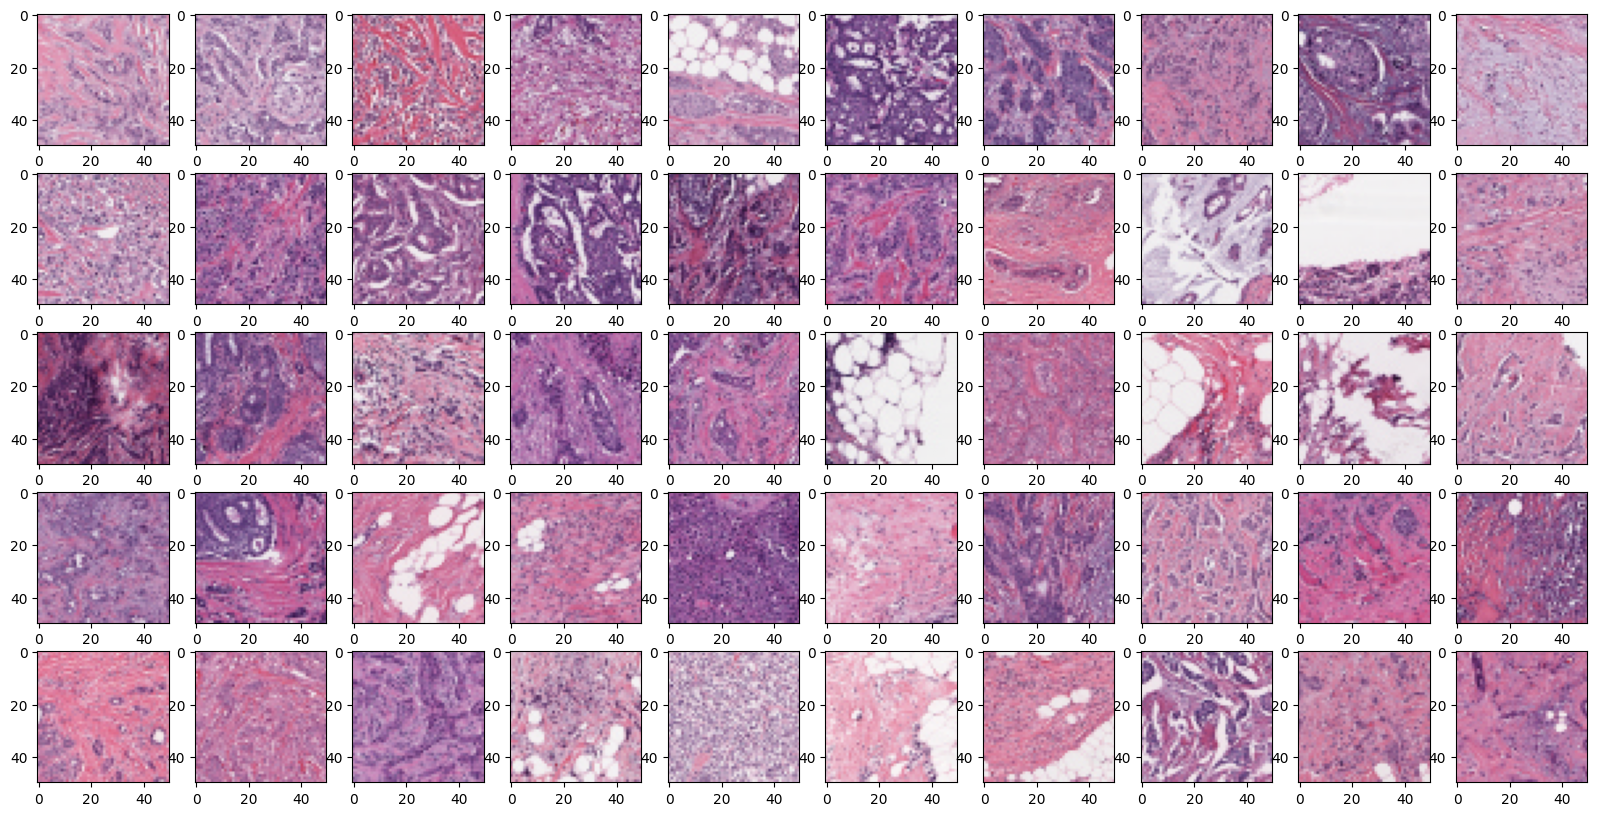

In [11]:
fig, ax = plt.subplots(5,10,figsize=(20,10))
for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        path =os.path.join(all_rays_dir,data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

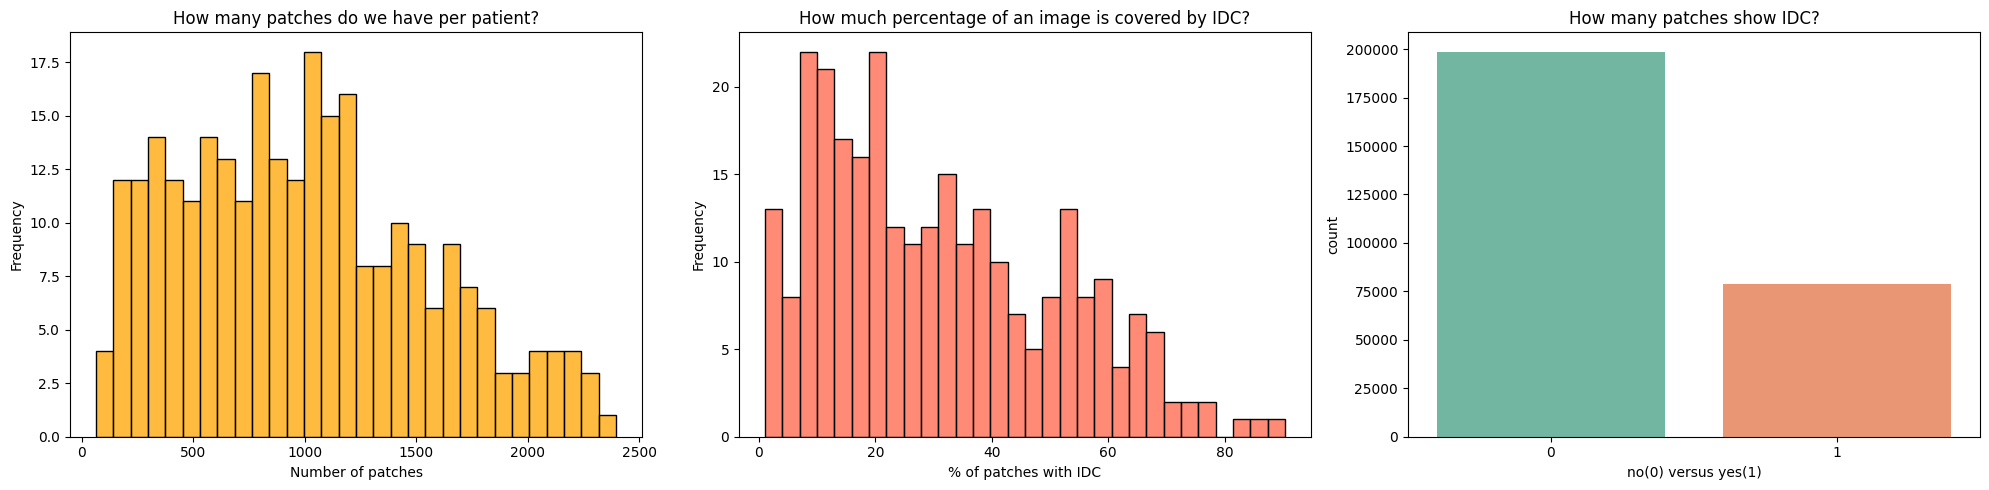

In [12]:
import warnings
warnings.filterwarnings('ignore')

cancer_perc = data.groupby("patient_id").target.value_counts() / data.groupby("patient_id").target.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# Replace distplot with histplot
sns.histplot(data.groupby("patient_id").size(), ax=ax[0], color="Orange", bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency")
ax[0].set_title("How many patches do we have per patient?")

sns.histplot(cancer_perc.loc[:, 1] * 100, ax=ax[1], color="Tomato", bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC")

# Fix countplot by specifying x=
sns.countplot(x=data.target, palette="Set2", ax=ax[2])
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?")

plt.tight_layout()
plt.show()


In [13]:
def extract_coords(df):
    coord = df.path.str.rsplit("_", n=4, expand=True)
    coord = coord.drop([0, 1, 4], axis=1)
    coord = coord.rename({2: "x", 3: "y"}, axis=1)
    coord.loc[:, "x"] = coord.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    coord.loc[:, "y"] = coord.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    df.loc[:, "x"] = coord.x.values
    df.loc[:, "y"] = coord.y.values
    return df

def get_cancer_dataframe(patient_id, cancer_id):
    path = cancer_rays_dir_str + patient_id + "/" + cancer_id
    files = os.listdir(path)
    dataframe = pd.DataFrame(files, columns=["filename"])
    path_names = path + "/" + dataframe.filename.values
    dataframe = dataframe.filename.str.rsplit("_", n=4, expand=True)
    
    # FIX: Replace np.int with int
    dataframe.loc[:, "target"] = int(cancer_id)
    
    dataframe.loc[:, "path"] = path_names
    dataframe = dataframe.drop([0, 1, 4], axis=1)
    dataframe = dataframe.rename({2: "x", 3: "y"}, axis=1)
    
    # FIX: Replace np.int with int
    dataframe.loc[:, "x"] = dataframe.loc[:,"x"].str.replace("x", "", case=False).astype(int)
    dataframe.loc[:, "y"] = dataframe.loc[:,"y"].str.replace("y", "", case=False).astype(int)
    
    return dataframe

def get_patient_dataframe(patient_id):
    df_0 = get_cancer_dataframe(patient_id, "0")
    df_1 = get_cancer_dataframe(patient_id, "1")
    
    # FIX: Use pd.concat() instead of .append()
    patient_df = pd.concat([df_0, df_1], ignore_index=True)
    
    return patient_df

example = get_patient_dataframe(data.patient_id.values[0])
example.head()


x     y  target                                               path
0  1001  1001       0  dataset 1/IDC_regular_ps50_idx5/10253/0/10253_...
1  1001  1051       0  dataset 1/IDC_regular_ps50_idx5/10253/0/10253_...
2  1001  1101       0  dataset 1/IDC_regular_ps50_idx5/10253/0/10253_...
3  1001  1151       0  dataset 1/IDC_regular_ps50_idx5/10253/0/10253_...
4  1001  1201       0  dataset 1/IDC_regular_ps50_idx5/10253/0/10253_...

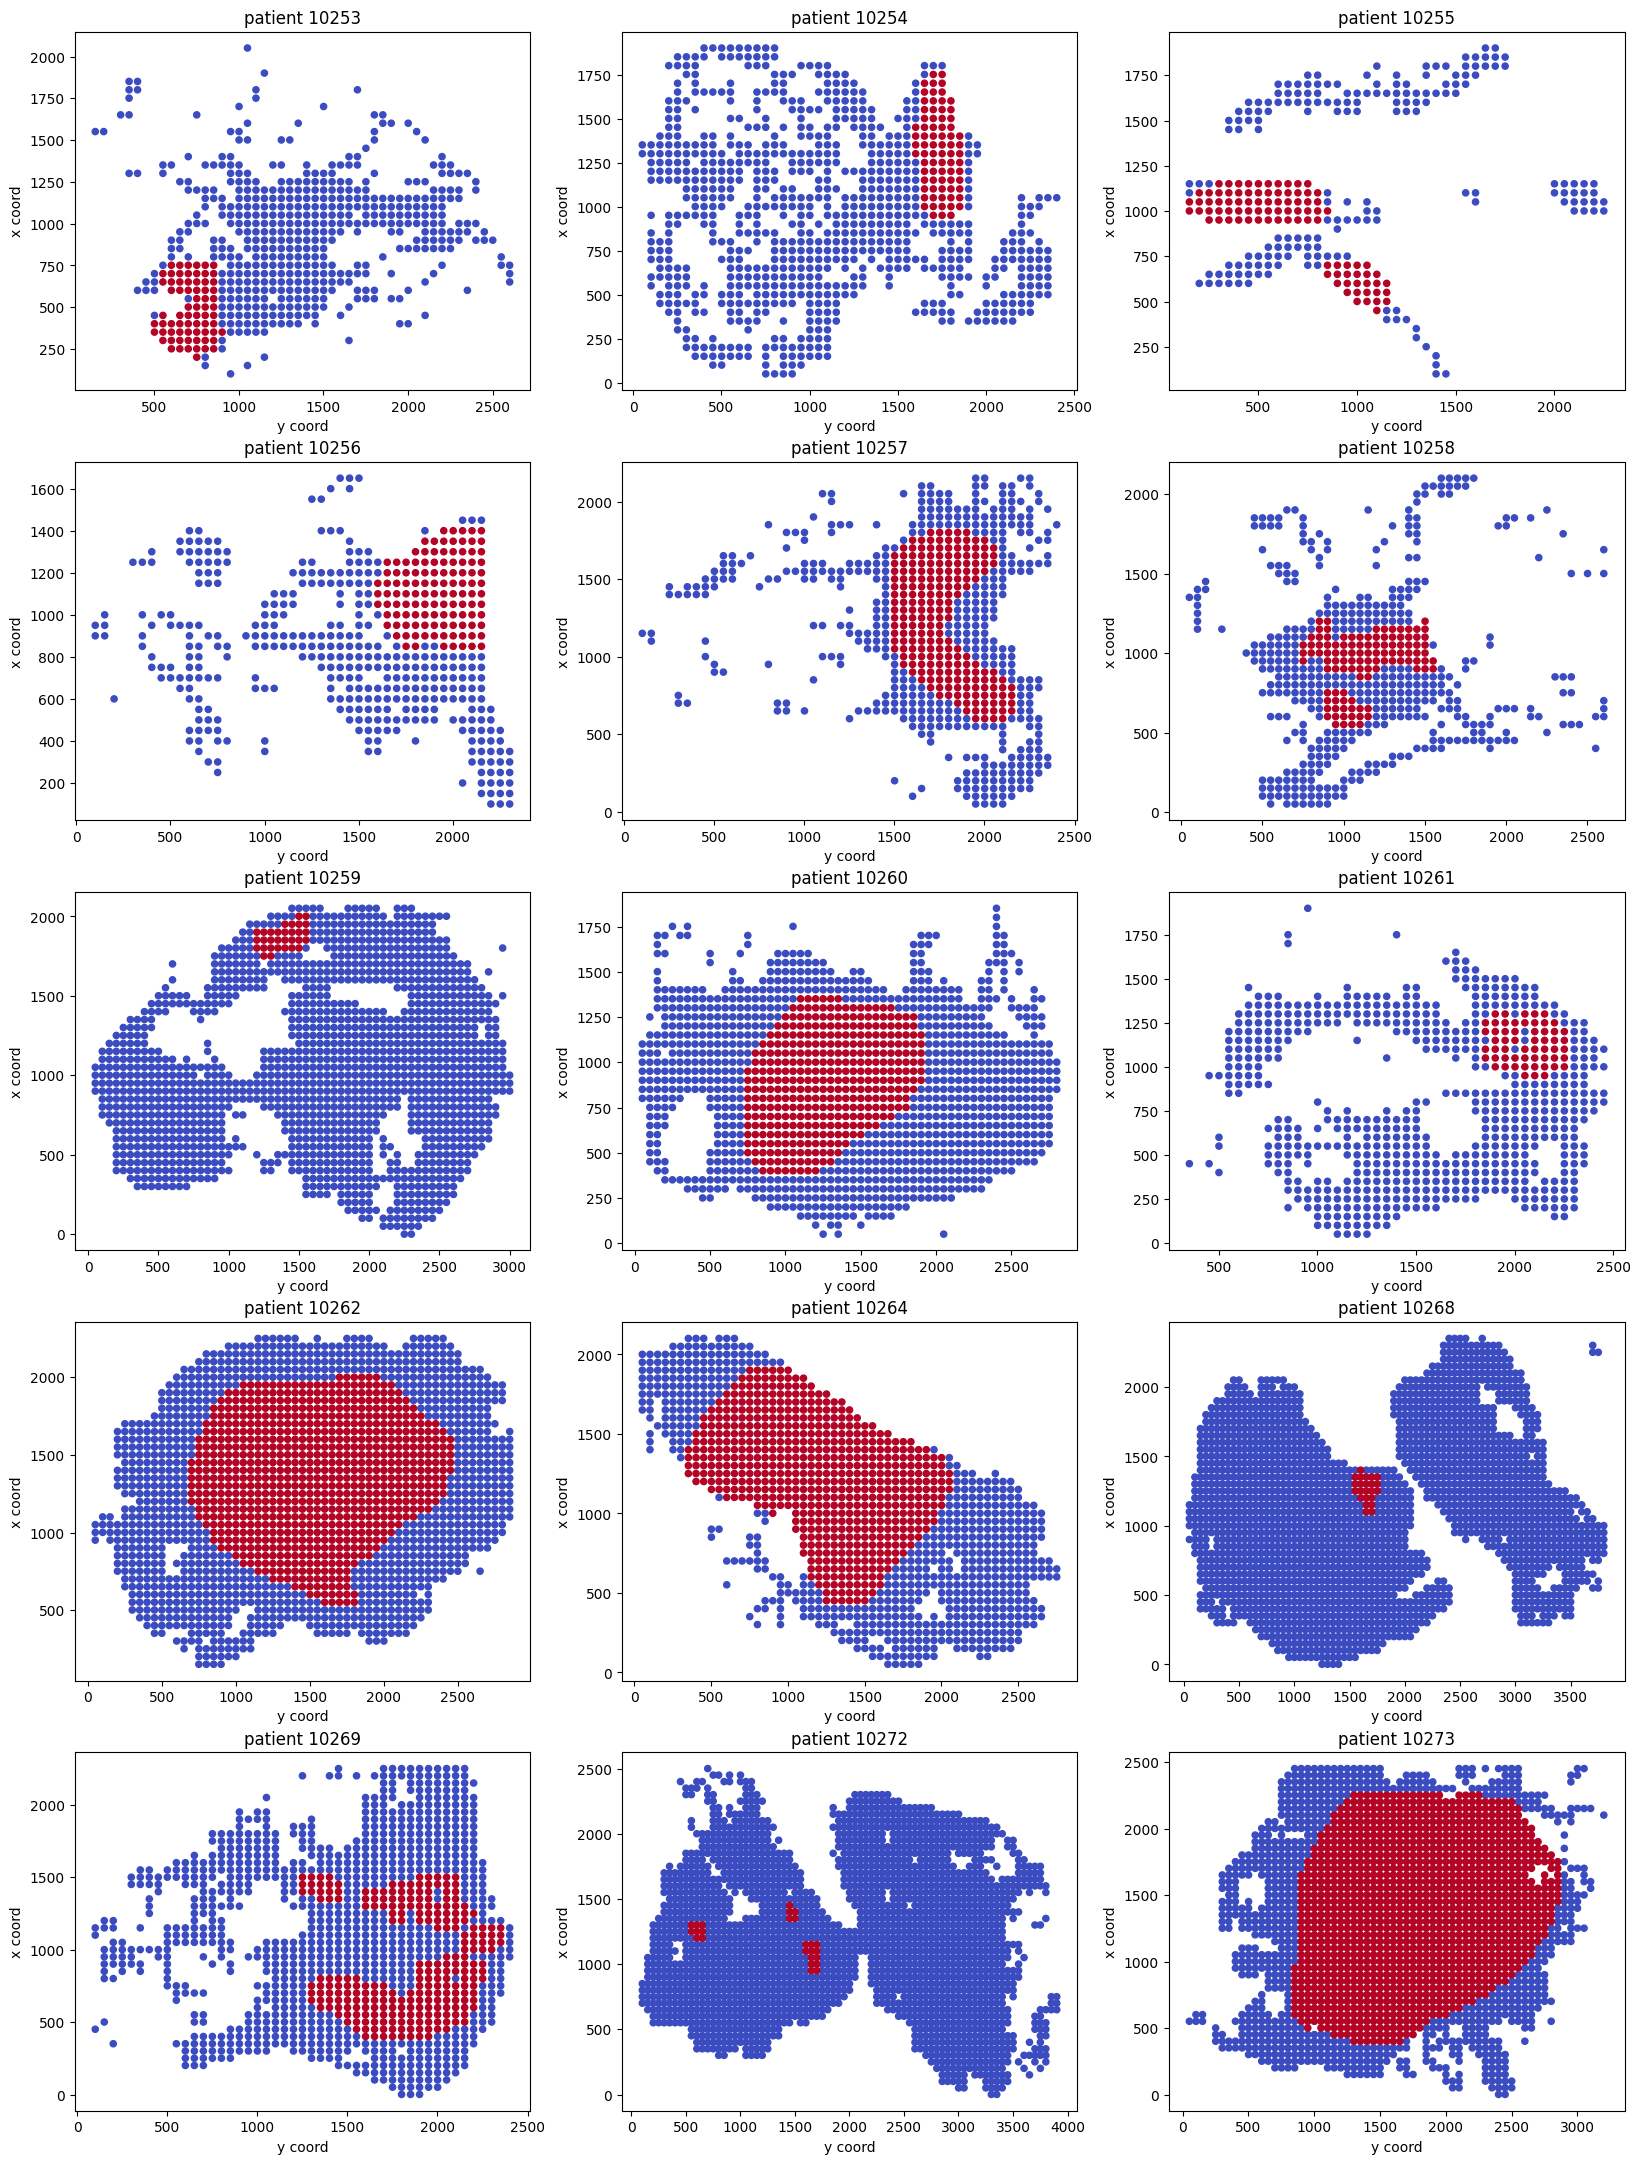

In [14]:
fig, ax = plt.subplots(5,3,figsize=(20, 27))

patient_ids = data.patient_id.unique()

for n in range(5):
    for m in range(3):
        patient_id = patient_ids[m + 3*n]
        example_df = get_patient_dataframe(patient_id)
        
        ax[n,m].scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
        ax[n,m].set_title("patient " + patient_id)
        ax[n,m].set_xlabel("y coord")
        ax[n,m].set_ylabel("x coord")

## Image Preprocessing

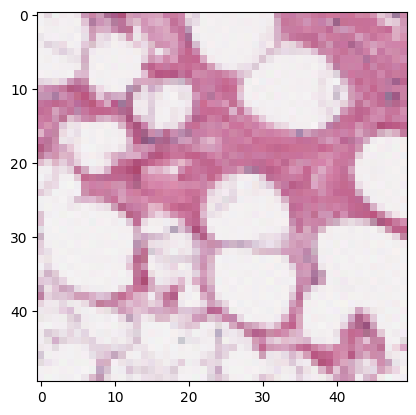

In [15]:
data.target = data.target.astype(int)  # Replace np.int with int

random_image_path = np.random.choice(data[data.target == 0].index, size=1, replace=False)
path = os.path.join(all_rays_dir, data.loc[random_image_path[0], 'image_id'])

image = mpimg.imread(path)
plt.imshow(image)
plt.show()  # Add this to properly display the image


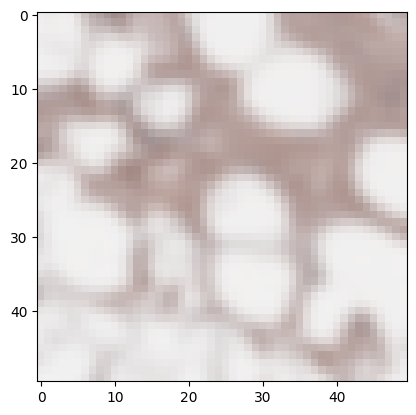

In [16]:
gaussian_image = gaussian(image)
plt.imshow(gaussian_image);

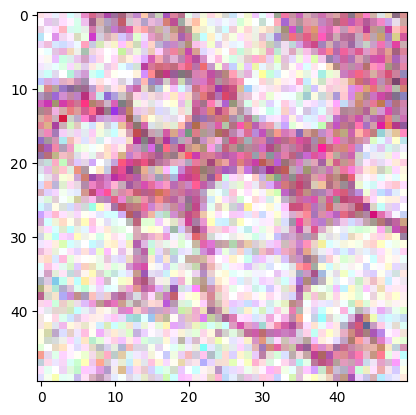

In [17]:
noise_image = random_noise(image)
plt.imshow(noise_image);

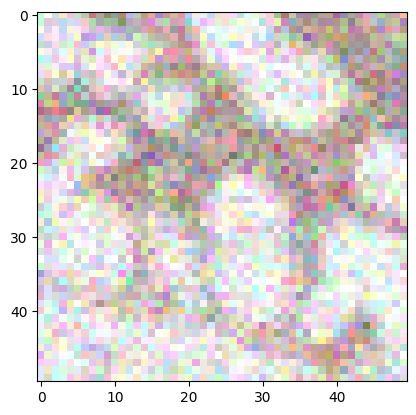

In [18]:
noise_gaussian_image = random_noise(gaussian_image)
plt.imshow(noise_gaussian_image);

In [20]:
#os.mkdir('image_processing') #We create a new file to process the data in
#os.mkdir('image_processing/noise_images')

In [20]:
#os.mkdir( 'image_processing/processd_data_train')
#os.mkdir( 'image_processing/processd_data_test')
#os.mkdir( 'image_processing/processd_data_train/zeros')
#os.mkdir( 'image_processing/processd_data_train/ones')
#os.mkdir( 'image_processing/processd_data_test/zeros')
#os.mkdir( 'image_processing/processd_data_test/ones')

In [21]:
processd_lst = os.listdir('image_processing/noise_images')
processd_lst_str = 'image_processing/noise_images'
processd_data = pd.DataFrame(processd_lst, columns=['image_id'])
processd_data.head()

image_id
0  10253_idx5_x1001_y1001_class0.png
1  10253_idx5_x1001_y1051_class0.png
2  10253_idx5_x1001_y1101_class0.png
3  10253_idx5_x1001_y1151_class0.png
4  10253_idx5_x1001_y1201_class0.png

In [22]:
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

processd_data['target'] = processd_data['image_id'].apply(extract_target)

processd_data.head(10)

image_id target
0  10253_idx5_x1001_y1001_class0.png      0
1  10253_idx5_x1001_y1051_class0.png      0
2  10253_idx5_x1001_y1101_class0.png      0
3  10253_idx5_x1001_y1151_class0.png      0
4  10253_idx5_x1001_y1201_class0.png      0
5  10253_idx5_x1001_y1251_class0.png      0
6  10253_idx5_x1001_y1301_class0.png      0
7  10253_idx5_x1001_y1351_class0.png      0
8  10253_idx5_x1001_y1501_class0.png      0
9  10253_idx5_x1001_y1551_class0.png      0

In [23]:
processd_data['target'].value_counts()

target
0    198738
1     78786
Name: count, dtype: int64

In [30]:
y = processd_data['target']
processd_train, processd_test = train_test_split(processd_data, test_size=0.10, random_state=101, stratify=y)
processd_test_pls =processd_test.image_id
processd_train_pls =processd_train.image_id

In [33]:
processd_data.set_index('image_id', inplace=True)
for image in processd_test_pls:
    fname = image
    target = processd_data.loc[image,'target']
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(processd_lst_str, fname)
    dst = os.path.join("image_processing/processd_data_test", label, fname)
    shutil.copyfile(src, dst)

In [34]:
for image in processd_train_pls:
    fname  = image
    target = processd_data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(processd_lst_str, fname)
    dst = os.path.join('image_processing/processd_data_train', label, fname)
    shutil.copyfile(src, dst)

In [35]:
print(len(os.listdir('image_processing/processd_data_train/zeros')))
print(len(os.listdir('image_processing/processd_data_train/ones')))
print(len(os.listdir('image_processing/processd_data_test/zeros')))
print(len(os.listdir('image_processing/processd_data_test/ones')))

178864
70907
19874
7879


## Processing and Normal Test

In [36]:
processd_lst = os.listdir('image_processing/noise_images')
processd_lst_str = 'image_processing/noise_images'
processd_data = pd.DataFrame(processd_lst, columns=['image_id'])
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

processd_data['target'] = processd_data['image_id'].apply(extract_target)

processd_data.head(10)

image_id target
0  10253_idx5_x1001_y1001_class0.png      0
1  10253_idx5_x1001_y1051_class0.png      0
2  10253_idx5_x1001_y1101_class0.png      0
3  10253_idx5_x1001_y1151_class0.png      0
4  10253_idx5_x1001_y1201_class0.png      0
5  10253_idx5_x1001_y1251_class0.png      0
6  10253_idx5_x1001_y1301_class0.png      0
7  10253_idx5_x1001_y1351_class0.png      0
8  10253_idx5_x1001_y1501_class0.png      0
9  10253_idx5_x1001_y1551_class0.png      0

In [37]:
#os.mkdir( 'image_processing/model_tst')
#os.mkdir( 'image_processing/model_tst/trainig')
#os.mkdir( 'image_processing/model_tst/testing')          
#os.mkdir( 'image_processing/model_tst/trainig/zeros')
#os.mkdir( 'image_processing/model_tst/trainig/ones')
#os.mkdir( 'image_processing/model_tst/testing/zeros')
#os.mkdir( 'image_processing/model_tst/testing/ones')

In [38]:
df_0 = processd_data[processd_data['target'] == '0'].sample(10000, random_state=101)
df_1 = processd_data[processd_data['target'] == '1'].sample(10000, random_state=101)
test_data =pd.DataFrame(data)
test_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
test_y = test_data['target']
test_data_train, test_data_test = train_test_split(test_data, test_size=0.10, random_state=101, stratify=test_y)
sts_train = test_data_train.image_id
tst_test  = test_data_test.image_id
test_data.set_index('image_id', inplace=True)
#for image in sts_train:
 #   fname  = image
#    target = test_data.loc[image,'target']
    
  #  if target == '0':
#      label = 'zeros'
 #   if target == '1':
  #      label = 'ones'
  #  src = os.path.join(all_rays_dir, fname)
#    dst = os.path.join('image_processing/model_tst/trainig', label, fname)
   # shutil.copyfile(src, dst)
#for image in tst_test:
 #   fname  = image
  #  target = test_data.loc[image,'target']
    
   # if target == '0':
    #    label = 'zeros'
   # if target == '1':
    #    label = 'ones'
#    src = os.path.join(all_rays_dir, fname)
 #   dst = os.path.join('image_processing/model_tst/testing', label, fname)
  #  shutil.copyfile(src, dst)

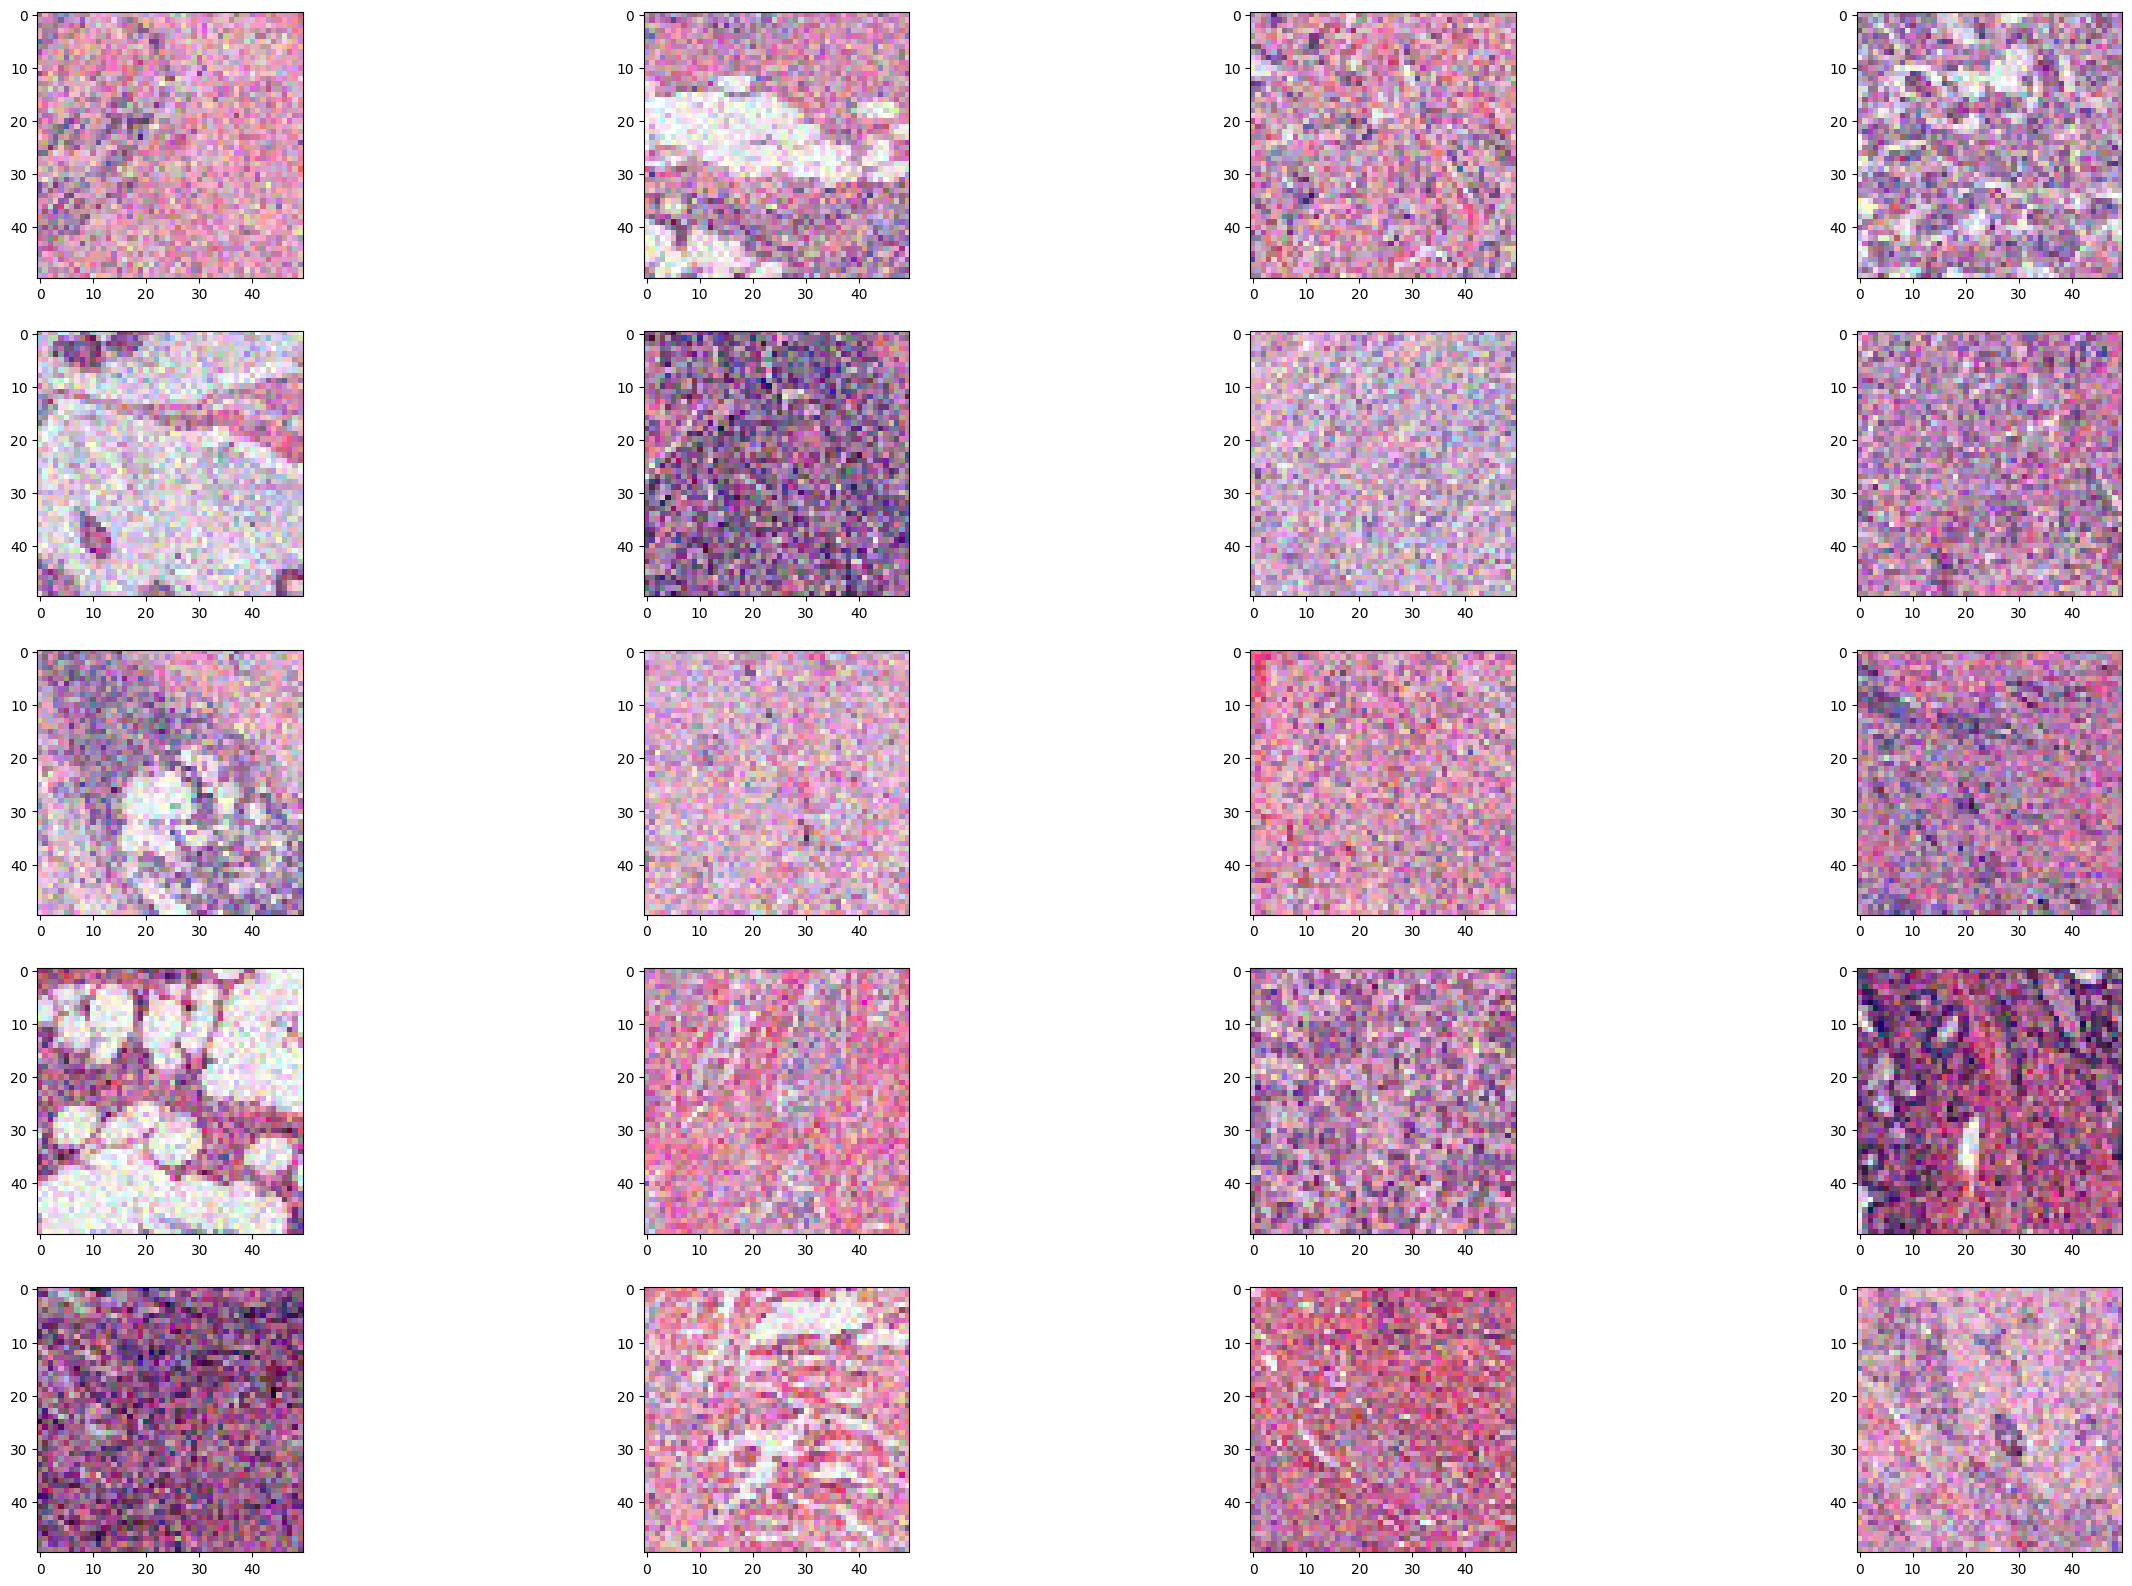

In [39]:
# Replace np.int with int
processd_data.target = processd_data.target.astype(int)

fig, ax = plt.subplots(5, 4, figsize=(30, 20))

# Select random positive and negative samples
pos_selection = np.random.choice(processd_data[processd_data.target == 1].index.values, size=20, replace=False)
neg_selection = np.random.choice(processd_data[processd_data.target == 0].index.values, size=20, replace=False)

# Loop to display images
for n in range(5):
    for m in range(4):
        idx = pos_selection[m + 4 * n]  # Get index
        path = os.path.join(processd_lst_str, processd_data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n, m].imshow(image)
        ax[n, m].grid(False)

plt.show()  # Ensure images are displayed


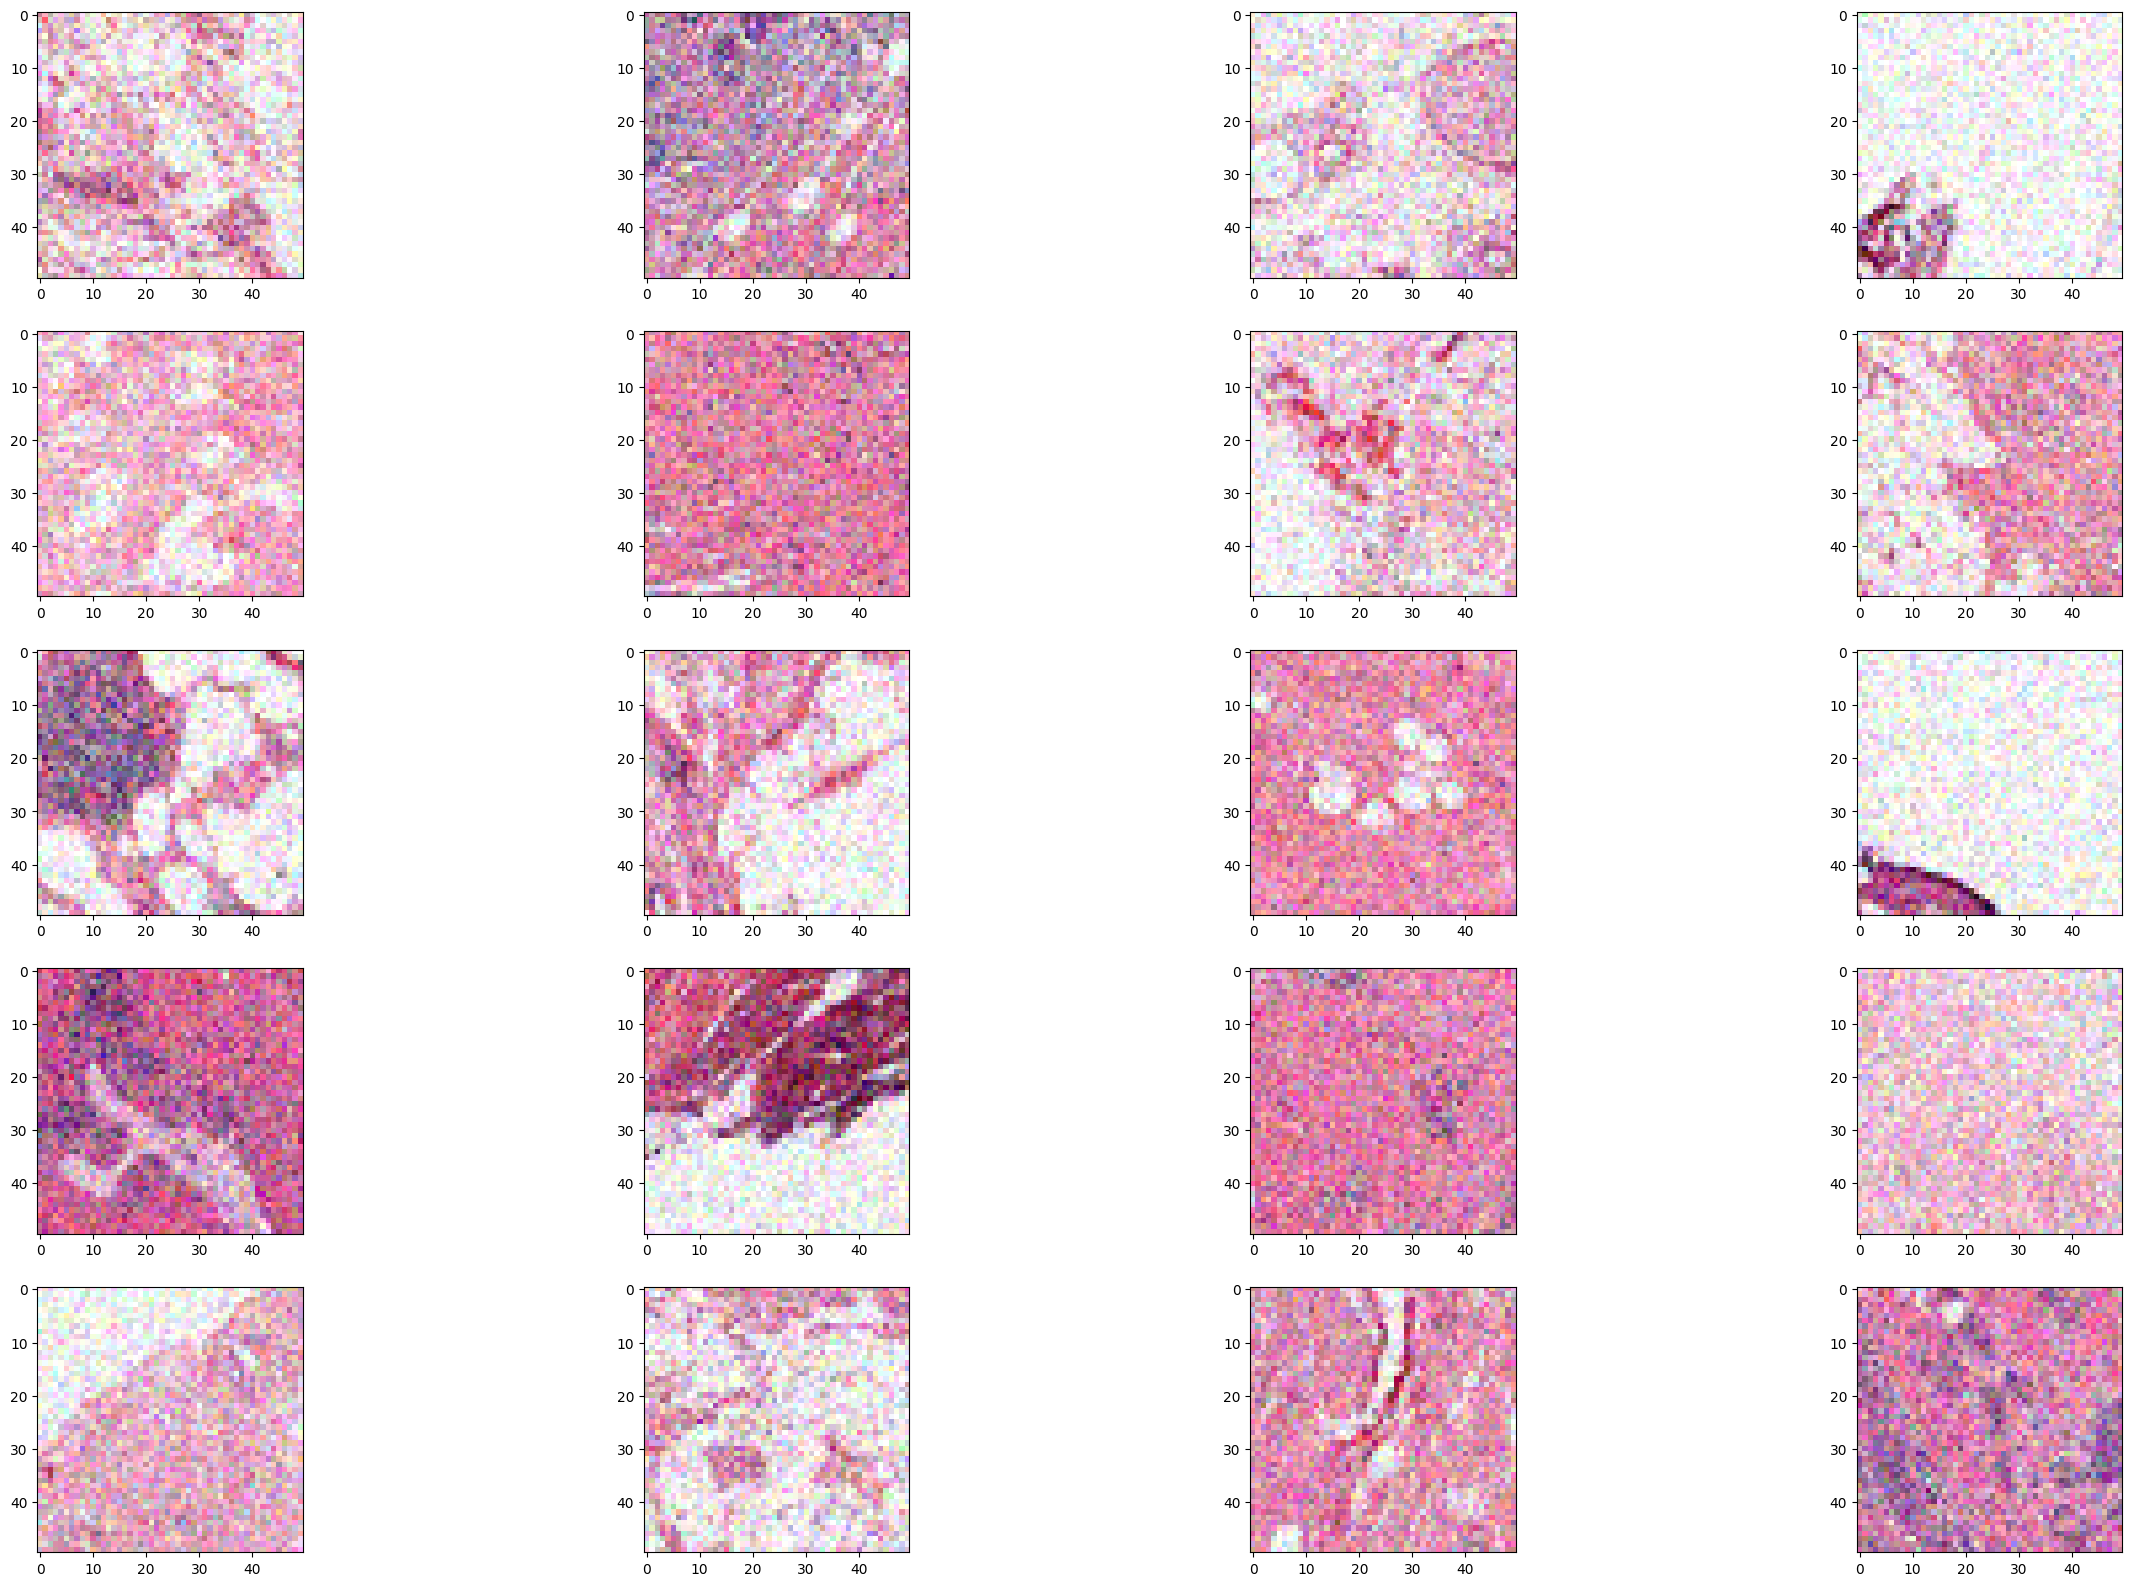

In [40]:
fig, ax = plt.subplots(5,4,figsize=(30,20))
for n in range(5):
    for m in range(4):
        idx = neg_selection[m + 4*n]
        path =os.path.join(processd_lst_str,processd_data.loc[idx, 'image_id'])
        image = mpimg.imread(path)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

In [41]:
data_processd_test_generation = ImageDataGenerator(rescale=1.0/255)
train_generation_processd = data_processd_test_generation.flow_from_directory("image_processing/model_tst/trainig", target_size=(50,50), batch_size=10,class_mode='categorical')
test_generation_processd = data_processd_test_generation.flow_from_directory("image_processing/model_tst/testing",target_size=(50,50),batch_size=10,class_mode='categorical')

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [42]:
my_model_im_processd =Sequential()
my_model_im_processd.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
my_model_im_processd.add(MaxPool2D(pool_size=(2,2)))


my_model_im_processd.add(Flatten())

my_model_im_processd.add(Dense(128,activation='relu'))

my_model_im_processd.add(Dense(2,activation='softmax'))

my_model_im_processd.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

In [43]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# Use fit() instead of fit_generator()
my_model_im_processd.fit(
    train_generation_processd,
    validation_data=test_generation_processd,
    epochs=60,
    verbose=1,
    callbacks=[early_stop]  # Wrap early_stop in a list
)


Epoch 1/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 112s 61ms/step - accuracy: 0.6927 - loss: 0.6052 - val_accuracy: 0.7740 - val_loss: 0.4830
Epoch 2/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 95s 53ms/step - accuracy: 0.7735 - loss: 0.4920 - val_accuracy: 0.8010 - val_loss: 0.4605
Epoch 3/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 91s 51ms/step - accuracy: 0.7919 - loss: 0.4644 - val_accuracy: 0.7665 - val_loss: 0.5078
Epoch 4/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 101s 56ms/step - accuracy: 0.7921 - loss: 0.4587 - val_accuracy: 0.7930 - val_loss: 0.4585
Epoch 5/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 96s 53ms/step - accuracy: 0.8028 - loss: 0.4379 - val_accuracy: 0.8070 - val_loss: 0.4403
Epoch 6/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 93s 52ms/step - accuracy: 0.8053 - loss: 0.4363 - val_accuracy: 0.8030 - val_loss: 0.4503
Epoch 7/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 100s 56ms/step - accuracy: 0.8098 - loss: 0.4267 - val_accuracy: 0.7875 - val_loss: 0.4745


## Second the normal images

In [44]:
#os.mkdir( 'image_processing/normal')
#os.mkdir( 'image_processing/normal/model_tst') 
#os.mkdir( 'image_processing/normal/model_tst/trainig')
#os.mkdir( 'image_processing/normal/model_tst/testing')
#os.mkdir( 'image_processing/normal/model_tst/trainig/zeros')
#os.mkdir( 'image_processing/normal/model_tst/trainig/ones')
#os.mkdir( 'image_processing/normal/model_tst/testing/zeros')
#os.mkdir( 'image_processing/normal/model_tst/testing/ones')

In [45]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
data['target'] = data['image_id'].apply(extract_target)
df_0 = data[data['target'] == '0'].sample(10000, random_state=101)
df_1 = data[data['target'] == '1'].sample(10000, random_state=101)
test_data =pd.DataFrame(data)
test_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
test_y = test_data['target']
test_data_train, test_data_test = train_test_split(test_data, test_size=0.10, random_state=101, stratify=test_y)
sts_train = test_data_train.image_id
tst_test  = test_data_test.image_id
test_data.set_index('image_id', inplace=True)
#for image in sts_train:
#    fname  = image
#    target = test_data.loc[image,'target']
#    
#    if target == '0':
#        label = 'zeros'
#    if target == '1':
#        label = 'ones'
#    src = os.path.join(all_rays_dir, fname)
#    dst = os.path.join('image_processing/normal/model_tst/trainig', label, fname)
#    shutil.copyfile(src, dst)
#for image in tst_test:
#    fname  = image
#    target = test_data.loc[image,'target']
    
#    if target == '0':
#        label = 'zeros'
#    if target == '1':
#        label = 'ones'
#    src = os.path.join(all_rays_dir, fname)
#    dst = os.path.join('image_processing/normal/model_tst/testing', label, fname)
#    shutil.copyfile(src, dst)

In [46]:
data_normal_test_generation = ImageDataGenerator(rescale=1.0/255)
train_generation_normal = data_normal_test_generation.flow_from_directory("image_processing/normal/model_tst/trainig", target_size=(50,50), batch_size=10,class_mode='categorical')
test_generation_normal = data_normal_test_generation.flow_from_directory("image_processing/normal/model_tst/testing",target_size=(50,50),batch_size=10,class_mode='categorical')

Found 18000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [47]:
my_model_im_norm =Sequential()
my_model_im_norm.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(50,50,3),activation='relu'))
my_model_im_norm.add(MaxPool2D(pool_size=(2,2)))


my_model_im_norm.add(Flatten())

my_model_im_norm.add(Dense(128,activation='relu'))
my_model_im_norm.add(Dense(2,activation='softmax'))

my_model_im_norm.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

In [48]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# Use fit() instead of fit_generator()
my_model_im_processd.fit(
    train_generation_normal,
    validation_data=test_generation_normal,
    epochs=60,
    verbose=1,
    callbacks=[early_stop]  # Wrap early_stop in a list
)


Epoch 1/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 134s 74ms/step - accuracy: 0.8162 - loss: 0.4098 - val_accuracy: 0.7945 - val_loss: 0.4555
Epoch 2/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 472s 262ms/step - accuracy: 0.8229 - loss: 0.4060 - val_accuracy: 0.7960 - val_loss: 0.4698
Epoch 3/60
1800/1800 ━━━━━━━━━━━━━━━━━━━━ 85s 47ms/step - accuracy: 0.8297 - loss: 0.3944 - val_accuracy: 0.8010 - val_loss: 0.4679


#### Conclusion: Normal imagers are best

## Modeling

## Data spliting and Generation

In [49]:
data = pd.DataFrame(all_rays_dir_lst, columns=['image_id'])
def extract_target(x):
    a = x.split('_')
    b = a[4]
    target = b[5] 
    return target

data['target'] = data['image_id'].apply(extract_target)

data.head()

image_id target
0  10253_idx5_x1001_y1001_class0.png      0
1  10253_idx5_x1001_y1051_class0.png      0
2  10253_idx5_x1001_y1101_class0.png      0
3  10253_idx5_x1001_y1151_class0.png      0
4  10253_idx5_x1001_y1201_class0.png      0

In [50]:
y = data['target']
data_train, data_test = train_test_split(data, test_size=0.10, random_state=101, stratify=y)

In [51]:
print(data_train.shape)
print(data_test.shape)

(249771, 2)
(27753, 2)


In [53]:
#os.mkdir( 'train_dir')
#os.mkdir('test_dir')

In [54]:
#os.mkdir( 'train_dir/zeros')
#os.mkdir( 'train_dir/ones')

#os.mkdir( 'test_dir/zeros')
#os.mkdir( 'test_dir/ones')

In [55]:
train = data_train.image_id
test  = data_test.image_id

In [58]:
data.set_index('image_id', inplace=True)
for image in train:
    fname  = image
    target = data.loc[image,'target']
    
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join('train_dir', label, fname)
    shutil.copyfile(src, dst)

In [59]:
for image in test:
    fname = image
    target = data.loc[image,'target']
    if target == '0':
        label = 'zeros'
    if target == '1':
        label = 'ones'
    src = os.path.join(all_rays_dir, fname)
    dst = os.path.join("test_dir", label, fname)
    shutil.copyfile(src, dst)

In [60]:
print('non-IDC train      =',len(os.listdir('train_dir/zeros')))
print('IDC train          =',len(os.listdir('train_dir/ones')))
print('non-IDC validation =',len(os.listdir('test_dir/zeros')))
print('IDC validation     =',len(os.listdir('test_dir/ones')))

non-IDC train      = 178864
IDC train          = 70907
non-IDC validation = 19874
IDC validation     = 7879


In [61]:
data_generation = ImageDataGenerator(rescale=1.0/255)

In [62]:
train_generation = data_generation.flow_from_directory(
                                        "train_dir",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')
test_generation = data_generation.flow_from_directory(
                                        "test_dir",
                                        target_size=(25,25),
                                        batch_size=10,
                                        class_mode='categorical')

Found 249771 images belonging to 2 classes.
Found 27753 images belonging to 2 classes.


### Model Design

In [63]:
my_model =Sequential()
my_model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
my_model.add(Conv2D(filters=32,kernel_size=(4,4),input_shape=(25,25,3),activation='relu'))
my_model.add(MaxPool2D(pool_size=(2,2)))
my_model.add(Dropout(.3))

my_model.add(Flatten())

my_model.add(Dense(256,activation='relu'))

my_model.add(Dense(2,activation='softmax'))

my_model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics= ['accuracy'])

In [65]:
my_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 22, 22, 32)          │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 19, 19, 32)          │          16,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 9, 9, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9, 9, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2592)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         663,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 682,306 (2.60 MB)

 Trainable params: 682,306 (2.60 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

# Use fit() instead of fit_generator()
my_model.fit(
    train_generation,  # Training data generator
    validation_data=test_generation,  # Validation data generator
    epochs=60,
    verbose=1,
    callbacks=[early_stop]  # Ensure callbacks is inside a list
)


Epoch 1/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 5262s 210ms/step - accuracy: 0.8007 - loss: 0.4499 - val_accuracy: 0.8312 - val_loss: 0.3948
Epoch 2/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 867s 35ms/step - accuracy: 0.8326 - loss: 0.3914 - val_accuracy: 0.8453 - val_loss: 0.3610
Epoch 3/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 825s 33ms/step - accuracy: 0.8408 - loss: 0.3740 - val_accuracy: 0.8479 - val_loss: 0.3502
Epoch 4/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 760s 30ms/step - accuracy: 0.8451 - loss: 0.3643 - val_accuracy: 0.8455 - val_loss: 0.3598
Epoch 5/60
24978/24978 ━━━━━━━━━━━━━━━━━━━━ 765s 31ms/step - accuracy: 0.8483 - loss: 0.3564 - val_accuracy: 0.8441 - val_loss: 0.3681


### Outputs and Outcomes

In [67]:
losse = pd.DataFrame(my_model.history.history)
losse.head()

accuracy      loss  val_accuracy  val_loss
0  0.815699  0.423920      0.831225  0.394766
1  0.833708  0.387658      0.845314  0.360953
2  0.840266  0.373370      0.847908  0.350155
3  0.845010  0.363402      0.845530  0.359796
4  0.848365  0.356332      0.844125  0.368050

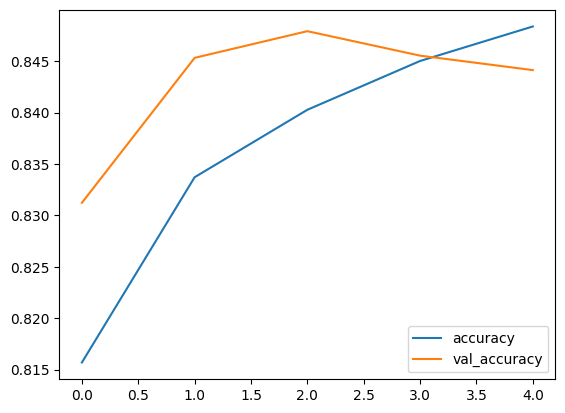

In [69]:
losse[['accuracy','val_accuracy']].plot();

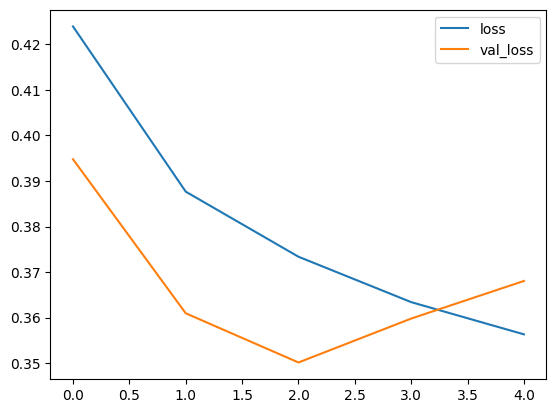

In [71]:
losse[['loss','val_loss']].plot();

In [74]:
val_loss, val_acc = my_model.evaluate(test_generation)


2776/2776 ━━━━━━━━━━━━━━━━━━━━ 66s 23ms/step - accuracy: 0.8448 - loss: 0.3682


In [75]:
print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.3680509626865387
val_acc: 0.844124972820282


In [76]:
model_json = my_model.to_json()

In [78]:
with open("model.json", "w") as json_file:
    json_file.write(model_json)
my_model.save_weights("model.weights.h5")
print("Saved model to disk")

Saved model to disk


In [79]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("model.weights.h5")
print("Loaded model from disk")
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Loaded model from disk
